In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)


In [3]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") 
df2=pd.read_csv("WBA.csv")  
df3=pd.read_csv("MTRAF.csv")
df4=pd.read_csv("COOP.csv") 
df5=pd.read_csv("JSAIY.csv")  
df6=pd.read_csv("ADRNY.csv")  
df7=pd.read_csv("TSCDY.csv")  
df8=pd.read_csv("KR.csv")    
df9=pd.read_csv("AGHC.csv")  
df10=pd.read_csv("CRRFY.csv") 
df11=pd.read_csv("WNGRF.csv") 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
df1

(1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8)


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2016-01-04,22.240000,22.809999,22.230000,22.790001,22.790001,385800
1,1,2016-01-05,22.610001,22.750000,22.480000,22.670000,22.670000,52600
2,2,2016-01-06,22.370001,22.520000,22.209999,22.389999,22.389999,66000
3,3,2016-01-07,22.350000,22.629999,22.150000,22.629999,22.629999,49900
4,4,2016-01-08,21.690001,22.030001,21.510000,21.570000,21.570000,69000
...,...,...,...,...,...,...,...,...
1001,1001,2019-12-24,18.150000,18.430000,18.150000,18.379999,18.379999,29000
1002,1002,2019-12-26,18.280001,18.370001,18.280001,18.299999,18.299999,50500
1003,1003,2019-12-27,18.690001,18.690001,18.280001,18.389999,18.389999,55100
1004,1004,2019-12-30,17.940001,18.290001,17.940001,18.230000,18.230000,70900


# Make models (train)

In [7]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], outputs_company=1, train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  print(f"[Arguments]") 
  print(f"num_company={len(nl)}社 {nl}")
  print(f"input_item={v}, outout_item={output_i}, output_category={output_c}")
  print(f"train_size={train_size}, time_step={time_step}, num_epoch={epochs}, num_units(neurons)={units}")
  print("")

  print("~~Make models~~")
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print("SECTOR1")
    # print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    # print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("SECTOR1-1")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      # print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("SECTOR1-2")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      # print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    print("SECTOR2")
    if V:
      print("SECTOR2-1")

      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))
      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)

      # print(f"concat={ss_v.shape}")

      ind = [id for id in range(len(c))]
      # print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(ss_v[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(ss_v[j, ind[k]])

    else: # volume含まれていない時
      print("SECTOR2-2")
      # from sklearn.preprocessing import MinMaxScaler#確認用
      # ss３=MinMaxScaler(feature_range=(0,1))

      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()

      concat=ss2.fit_transform(training_set_all)

      ind = [id for id in range(len(c))]

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  model_lists = []
  
  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")

    model = Sequential()

    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  return model_lists, y_trains2[:outputs_company]

# Make predictions (test)


In [8]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  print("~~Make predctions~~")
  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual lists={np.array(actual_lists).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(r)
  for p in range(len(R2)):
    plt.figure(figsize=(10, 6)) 
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists[p], color='red', label='Real')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    from sklearn.metrics import r2_score

    plt.xticks(np.arange(0, 300, 30))
    # plt.title(f"{}")
    plt.xlabel('Time series')
    plt.ylabel('Stock Price (or Volume)')
    
    # use correlation
    print(f"R2{R2[p]}={r2_score(actual_lists[p], preds[p].flatten())}")
 
    R +=r2_score(actual_lists[p], preds[p].flatten())
    plt.legend()
    plt.show()

    if p in r:
      print(f"R2-{len(c)}companies_average={R/len(c)}")
      R=0
      print("")

  #6. Make confusion matrix

  columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  for p in range(len(output_i)):
    print(f"Preds_Heatmap={output_c[p]} correlation")
    prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
    # print(len(prd))
    Preds= pd.DataFrame(np.concatenate(prd, axis=1))
    Preds.columns = columns
    # print(Preds.columns)
    plt.figure(figsize=(8, 6))
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# 6月22日以降　


## ALL in ALL Function

In [4]:
all_data=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

def all_in_all(all_data, num_company=11, input_num=[2], output_category=['High'], output_num=[2], outputs_company=11, 
               train_size=754, time_step=60, epochs=20, units=50):

  company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]
  
  all_data=all_data[:num_company]
  company_list=company_list[:num_company]

  if 6 not in input_num: Volume=False
  else: Volume=True

  # Make Models
  model_lists, y_trains = make_models(all_data, company_list, input_num, Volume, output_category, 
                                      output_num, outputs_company, train_size, time_step, epochs, units)
  # Make Predictions               
  make_preds(all_data, company_list, input_num, model_lists, y_trains, Volume, output_category, output_num, train_size, time_step)

## 流れ
### 1. Randomで会社を選定
### 2. Trainningデータも同時に表示
### 3. Subprot表示に対応(4✖︎2構成)

[Arguments]
num_company=2社 ['Seven & I Holdings (Japan)', 'Walgreens Boots Alliance (USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=880, time_step=60, num_epoch=10, num_units(neurons)=30

~~Make models~~
train_data=(2, 880, 1), test_data=(2, 126, 1)
SECTOR2
SECTOR2-2
X_train=(820, 60, 2), y_trains=(1640,)
y_trains2=(2, 820)
1/2
Epoch 1/10
26/26 [==============================] - 23s 88ms/step - loss: 0.7837
Epoch 2/10
26/26 [==============================] - 2s 90ms/step - loss: 0.2622
Epoch 3/10
26/26 [==============================] - 2s 89ms/step - loss: 0.2214
Epoch 4/10
26/26 [==============================] - 2s 92ms/step - loss: 0.2116
Epoch 5/10
26/26 [==============================] - 2s 89ms/step - loss: 0.1977
Epoch 6/10
26/26 [==============================] - 2s 90ms/step - loss: 0.1745
Epoch 7/10
26/26 [==============================] - 2s 89ms/step - loss: 0.1595
Epoch 8/10
26/26 [==============================] - 2s 88ms/step - loss: 0.1702


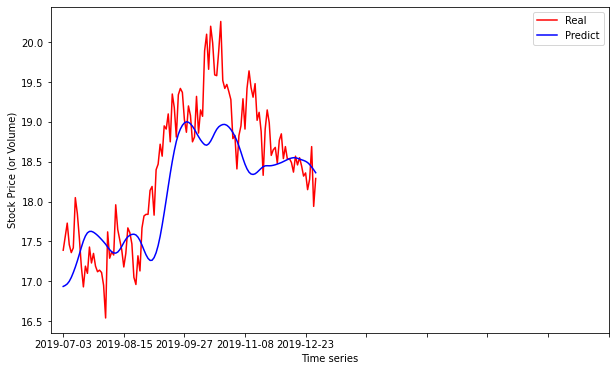

R2Walgreens Boots Alliance (USA)=0.5582288450105681


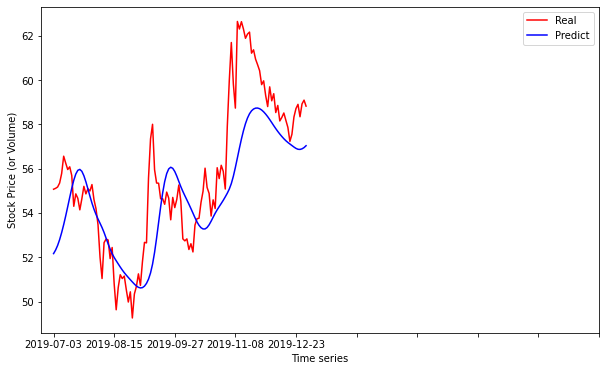

R2-2companies_average=0.5594227940922084

Preds_Heatmap=High correlation


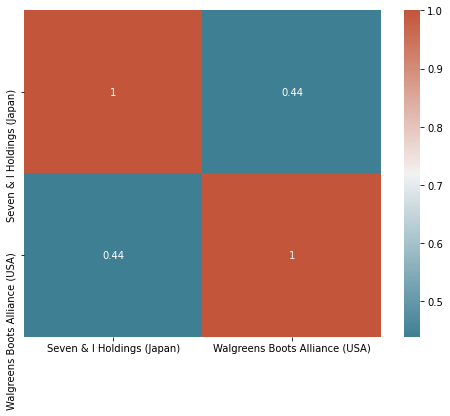

In [9]:
all_in_all(all_data, num_company=2, input_num=[2], output_category=['High'], output_num=[2], outputs_company=2,
           train_size=754+126, time_step=60, epochs=10, units=30)

###Seven & I Holdings (Japan) 1社の例 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [ ]:
data = df1
data

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2016-01-04,22.240000,22.809999,22.230000,22.790001,22.790001,385800
1,1,2016-01-05,22.610001,22.750000,22.480000,22.670000,22.670000,52600
2,2,2016-01-06,22.370001,22.520000,22.209999,22.389999,22.389999,66000
3,3,2016-01-07,22.350000,22.629999,22.150000,22.629999,22.629999,49900
4,4,2016-01-08,21.690001,22.030001,21.510000,21.570000,21.570000,69000
...,...,...,...,...,...,...,...,...
1001,1001,2019-12-24,18.150000,18.430000,18.150000,18.379999,18.379999,29000
1002,1002,2019-12-26,18.280001,18.370001,18.280001,18.299999,18.299999,50500
1003,1003,2019-12-27,18.690001,18.690001,18.280001,18.389999,18.389999,55100
1004,1004,2019-12-30,17.940001,18.290001,17.940001,18.230000,18.230000,70900


In [ ]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce') #turning the Close column to numeric
data = data.dropna() #romeving the NA values
trainData = data.iloc[:,4:5].values #selecting only the closing prices for training
trainData.shape

(1006, 1)

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1006, 1)

In [ ]:
X_train = []
y_train = []

for i in range (60, 946): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)
y_train.shape

(886,)

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(886, 60, 1)

In [ ]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam', loss="mean_squared_error")

In [ ]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
28/28 - 13s - loss: 0.0448
Epoch 2/20
28/28 - 5s - loss: 0.0128
Epoch 3/20
28/28 - 5s - loss: 0.0112
Epoch 4/20
28/28 - 5s - loss: 0.0110
Epoch 5/20
28/28 - 5s - loss: 0.0092
Epoch 6/20
28/28 - 6s - loss: 0.0084
Epoch 7/20
28/28 - 5s - loss: 0.0092
Epoch 8/20
28/28 - 5s - loss: 0.0099
Epoch 9/20
28/28 - 5s - loss: 0.0089
Epoch 10/20
28/28 - 5s - loss: 0.0088
Epoch 11/20
28/28 - 5s - loss: 0.0083
Epoch 12/20
28/28 - 5s - loss: 0.0075
Epoch 13/20
28/28 - 5s - loss: 0.0087
Epoch 14/20
28/28 - 5s - loss: 0.0074
Epoch 15/20
28/28 - 5s - loss: 0.0069
Epoch 16/20
28/28 - 5s - loss: 0.0069
Epoch 17/20
28/28 - 5s - loss: 0.0063
Epoch 18/20
28/28 - 5s - loss: 0.0064
Epoch 19/20
28/28 - 5s - loss: 0.0066
Epoch 20/20
28/28 - 5s - loss: 0.0063


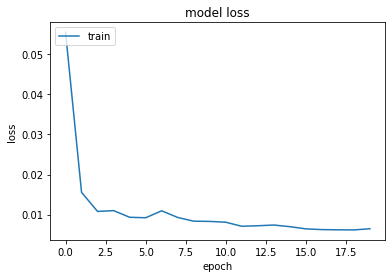

In [ ]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
testData = df1 #importing the test data
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #turning the close column to numerical type
testData = testData.dropna() #droping the NA values
testData = testData.iloc[:,4:5] #selecting the closing prices for testing
y_test = testData.iloc[60:,0:].values #selecting the labels 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep, length): #doing the same preivous preprocessing 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(946, 60, 1)

In [ ]:
y_pred = model.predict(X_test) #predicting the new values

In [ ]:
predicted_price = sc.inverse_transform(y_pred) #inversing the scaling transformation for ploting

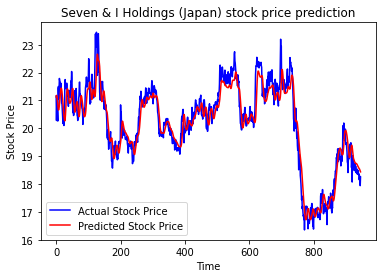

In [ ]:
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('Seven & I Holdings (Japan) stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()